In [1]:
import sys
print(sys.version)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [2]:
! pip uninstall tensorflow==2.17.0

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.17.1


In [3]:
!pip -q install tensorflow==2.8.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 35.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.10 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
google-cloud-aipla

# Model 2: Multivariate-10-RNN








In [ ]:
import sys
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
print(tf.__version__)


2.8.4


In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [ ]:
# Loading the dataset
url = 'vnindex.csv'
df = pd.read_csv(url,parse_dates = True , index_col = 0)

In [ ]:
# Correlation matrix
df.corr()['Close']

,Close
Open,0.999743
High,0.999847
Low,0.999879
Close,1.000000
Volume,0.780469


count    5.796000e+03
mean     1.796296e+08
std      2.720417e+08
min      0.000000e+00
25%      3.509555e+06
50%      6.246424e+07
75%      1.905016e+08
max      1.708781e+09
Name: Volume, dtype: float64


<Axes: >

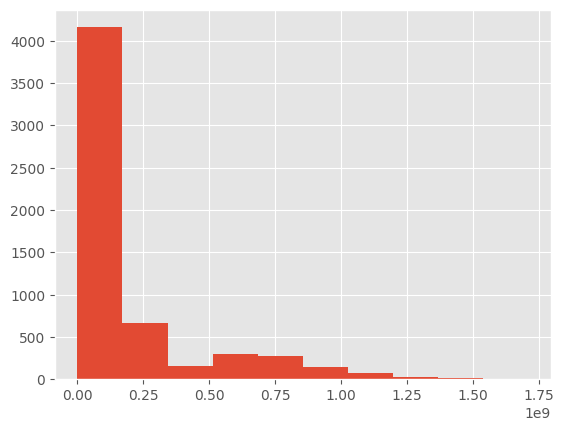

In [ ]:
# Distribution of Various Features
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df['Volume'].hist(bins = 10)

In [ ]:

# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [ ]:
print(df.head())

              Open    High     Low   Close  Volume  CMA10  SMA10  SMA50  \
Date                                                                      
2000-07-28  100.00  100.00  100.00  100.00    4200    NaN    NaN    NaN   
2000-07-28  100.00  100.00  100.00  100.00    4200    NaN    NaN    NaN   
2000-07-31  101.55  101.55  101.55  101.55   10300    NaN    NaN    NaN   
2000-08-02  103.38  103.38  103.38  103.38     300    NaN    NaN    NaN   
2000-08-04  105.20  105.20  105.20  105.20    3700    NaN    NaN    NaN   

                 EMA12       EMA26      MACD  RSI  CCI  %K  %D  
Date                                                            
2000-07-28  100.000000  100.000000  0.000000  NaN  NaN NaN NaN  
2000-07-28  100.000000  100.000000  0.000000  NaN  NaN NaN NaN  
2000-07-31  100.238462  100.114815  0.123647  NaN  NaN NaN NaN  
2000-08-02  100.721775  100.356680  0.365095  NaN  NaN NaN NaN  
2000-08-04  101.410733  100.715445  0.695288  NaN  NaN NaN NaN  


## Train model

In [ ]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

## Evaluate Model

In [ ]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200,250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_2(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart

In [ ]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## Model building

In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(5741, 10)
              Close     CMA10     SMA10      SMA50        EMA12        RSI  \
Date                                                                         
2024-05-17  1273.11  1262.710  1251.375  1248.9648  1247.819711  87.777032   
2024-05-20  1277.58  1264.433  1254.975  1249.1168  1252.398217  88.966405   
2024-05-21  1277.14  1267.183  1257.826  1249.4050  1256.204645  87.963171   
2024-05-22  1266.91  1271.028  1259.471  1249.3740  1257.851623  77.339102   
2024-05-23  1281.03  1272.853  1262.710  1250.0476  1261.417527  79.440628   

                   CCI         %K         %D       MACD  
Date                                                     
2024-05-17  123.577312  98.464390  97.046261   6.166349  
2024-05-20  129.388152  91.198242  95.444769   8.083623  
2024-05-21  106.944611  89.798505  93.153712   9.458539  
2024-05-22   92.565837  72.659288  84.552012   9.611895  
2024-05-23   97.499729  93.176972  85.211588  10.748890  


In [ ]:
series.describe()

,Close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000
mean,647.183472,647.083790,646.308636,642.429949,646.117879,53.171576,12.204349,54.732489,54.734869,1.355739
std,350.219893,349.906922,349.760854,347.673676,349.443595,21.273376,114.354740,34.043904,32.464218,15.071153
min,130.900000,132.823000,132.823000,124.991400,133.452809,0.000000,-476.059925,-19.753086,-4.973083,-62.563332
25%,392.570000,393.581000,393.114000,394.067600,393.801458,36.830283,-81.037179,22.850072,23.852481,-4.142768
50%,557.470000,557.630000,557.486000,559.076800,557.841043,53.119317,23.123691,59.369712,58.797326,0.848846
75%,958.670000,959.336000,958.907000,961.592800,960.498084,69.687901,104.967773,87.024946,85.785816,8.180682
max,1528.570000,1510.201000,1510.201000,1491.282800,1504.837223,100.000000,384.480432,128.715004,109.571668,80.364202


In [ ]:
# Train Val Test Split
train_start = dt.date(2000, 7, 28)                                     #train để huấn luyện mô hình
train_end = dt.date(2016, 5, 27)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2016, 5, 28)                                       #val để điều chỉnh siêu tham số và tránh overfitting
val_end = dt.date(2020, 5, 26)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2020, 5,27 )                                      #test để đánh giá hiệu suất
test_end = dt.date(2024, 5, 29)
test_data = series.loc[test_start:test_end]

print(train_data.shape, val_data.shape, test_data.shape)

(3737, 10) (1002, 10) (1002, 10)


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3737, 10) (1002, 10) (1002, 10)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 134: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 134: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 132: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 132: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 93: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 93: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 180: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 180: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 184: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 184: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 137: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 137: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 184: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 184: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 125: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 125: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 97: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 97: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 88: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 88: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 228: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 121: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 121: early stopping
Best Parameters: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}
Best RMSE Score: 0.01802532692525475
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.014043  0.118503   
1          30  [40, 35]  0.0010          32         250  0.014043  0.118503   
2          30  [40, 35]  0.0010          64         200  0.000384  0.019591   
3          30  [40, 35]  0.0010          64         250  0.000384  0.019591   
4          30  [40, 35]  0.0001          32         200  0.002551  0.050504   
5          30  [40, 35]  0.0001          32         250  0.002551  0.050504   
6          30  [40, 35]  0.0001          64         200  0.000695  0.026371   
7          30  [40, 35]  0.0001          64         250  0.000695  0.026371   
8          40  [40, 35]  0.0010          32         200  0.003717  0.060970   
9          40  [40, 35]  0.0010          32   

In [ ]:
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 88: early stopping


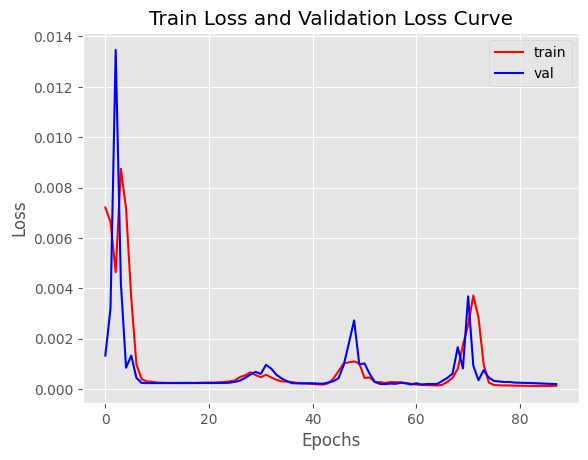

In [ ]:
model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.0003249124107623139
RMSE = 0.01802532692525475
MAPE = 0.01326440891284779
R-Squared Score = 0.986873002884702


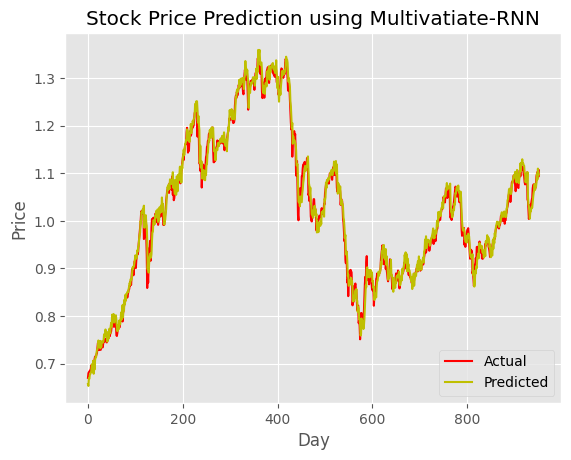

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_2(true, predicted)

In [ ]:
# Save a model
model.save('MV3-RNN_30_[50,45]_1e-3_32.h5')
del model

# Model 3: Multivariate-10-GRU


In [ ]:
import sys
import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

##Data preprocessing

In [ ]:
url = 'vnindex.csv'
df = pd.read_csv(url, parse_dates = True, index_col = 0)

In [ ]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [ ]:
df.head()

##Train Model


In [ ]:
def fit_model_3(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

##Evaluate Model


In [ ]:
def evaluate_model_3(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200,250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart


In [ ]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building


In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

In [ ]:
# Train Val Test Split
train_start = dt.date(2000, 7, 28)                                     #train để huấn luyện mô hình
train_end = dt.date(2016, 5, 27)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2016, 5, 28)                                       #val để điều chỉnh siêu tham số và tránh overfitting
val_end = dt.date(2020, 5, 25)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2020, 5,26 )                                      #test để đánh giá hiệu suất
test_end = dt.date(2024, 5, 29)
test_data = series.loc[test_start:test_end]

print(train_data.shape, val_data.shape, test_data.shape)

In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)


sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 123: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 123: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 186: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 186: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 88: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 88: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 230: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 123: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 123: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 88: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 88: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 234: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 133: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 133: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 141: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 141: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 88: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 88: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 243: early stopping
Best Parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}
Best RMSE Score: 0.015102325197971217
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.017597  0.132655   
1          30  [40, 35]  0.0010          32         250  0.017597  0.132655   
2          30  [40, 35]  0.0010          64         200  0.000228  0.015102   
3          30  [40, 35]  0.0010          64         250  0.000228  0.015102   
4          30  [40, 35]  0.0001          32         200  0.002124  0.046090   
5          30  [40, 35]  0.0001          32         250  0.002124  0.046090   
6          30  [40, 35]  0.0001          64         200  0.000749  0.027365   
7          30  [40, 35]  0.0001          64         250  0.000459  0.021415   
8          40  [40, 35]  0.0010          32         200  0.000477  0.021850   
9          40  [40, 35]  0.0010          32  

In [ ]:
timesteps = 30
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 186: early stopping


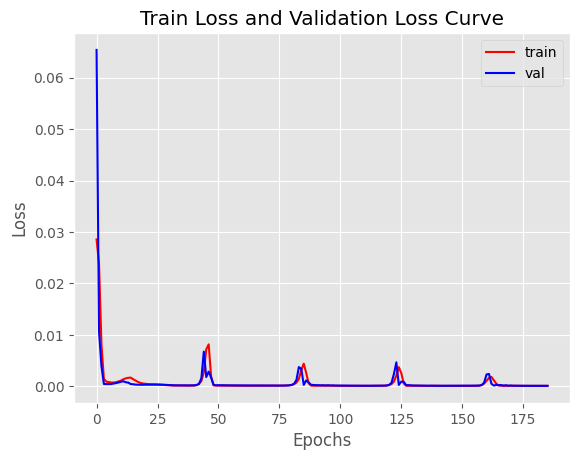

In [ ]:
model, train_error, val_error = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.00022808022638527638
RMSE = 0.015102325197971217
MAPE = 0.011141335439651326
R-Squared Score = 0.9914266747131221


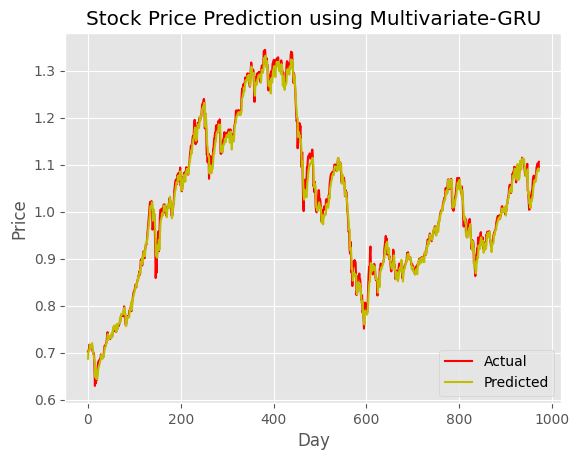

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_3(true, predicted)

In [ ]:
# Save a model
#model.save('MV3-GRU_40_[40,35]_1e-4_64.h5')
del model  #Deletes the model

# Model 4: Multivariate-10-LSTM

In [4]:
import sys
import numpy as np
np.random.seed(1)


import random as rn
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [5]:
print(tf.__version__)


2.8.4


In [6]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [7]:
# Loading the dataset
url = 'vnindex.csv'
df = pd.read_csv(url,parse_dates = True , index_col = 0)

In [8]:

# Correlation matrix
df.corr()['Close']

,Close
Open,0.999743
High,0.999847
Low,0.999878
Close,1.000000
Volume,0.780483


In [9]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    5.795000e+03
mean     1.796606e+08
std      2.720549e+08
min      0.000000e+00
25%      3.515590e+06
50%      6.251618e+07
75%      1.905479e+08
max      1.708781e+09
Name: Volume, dtype: float64


In [10]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2000-07-28,100.00,100.00,100.00,100.00,4200
2000-07-31,101.55,101.55,101.55,101.55,10300
2000-08-02,103.38,103.38,103.38,103.38,300
2000-08-04,105.20,105.20,105.20,105.20,3700
2000-08-07,106.92,106.92,106.92,106.92,13100
...,...,...,...,...,...
2024-05-23,1265.60,1281.03,1262.29,1281.03,968130000
2024-05-24,1276.68,1285.07,1250.28,1261.93,1367781161
2024-05-27,1263.46,1267.68,1257.27,1267.68,726703810


In [11]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()


In [12]:
df

,Open,High,Low,Close,Volume,CMA10,SMA10,SMA50,EMA12,EMA26,MACD,RSI,CCI,%K,%D
Date,,,,,,,,,,,,,,,
2000-07-28,100.00,100.00,100.00,100.00,4200,NaN,NaN,NaN,100.000000,100.000000,0.000000,NaN,NaN,NaN,NaN
2000-07-31,101.55,101.55,101.55,101.55,10300,NaN,NaN,NaN,100.238462,100.114815,0.123647,NaN,NaN,NaN,NaN
2000-08-02,103.38,103.38,103.38,103.38,300,NaN,NaN,NaN,100.721775,100.356680,0.365095,NaN,NaN,NaN,NaN
2000-08-04,105.20,105.20,105.20,105.20,3700,NaN,NaN,NaN,101.410733,100.715445,0.695288,NaN,NaN,NaN,NaN
2000-08-07,106.92,106.92,106.92,106.92,13100,NaN,NaN,NaN,102.258312,101.175041,1.083271,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,1265.60,1281.03,1262.29,1281.03,968130000,1272.853,1262.710,1250.0476,1261.417527,1250.668637,10.748890,79.440628,97.499729,93.176972,85.211588
2024-05-24,1276.68,1285.07,1250.28,1261.93,1367781161,NaN,1264.433,1250.5764,1261.496369,1251.502812,9.993557,60.129418,67.537068,54.948673,73.594978
2024-05-27,1263.46,1267.68,1257.27,1267.68,726703810,NaN,1267.183,1251.0300,1262.447697,1252.701122,9.746575,59.606657,55.489371,66.085609,71.403752


## Train Model


In [13]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation = 'relu', return_sequences = True))
    model.add(LSTM(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

## Evaluate Model

In [14]:
def evaluate_model_4(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [15]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200]  # Số epoch
}

In [16]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


##Plot chart

In [17]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [18]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building

In [19]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
series.describe()

(5740, 10)


,Close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000
mean,647.267354,647.168370,646.394605,642.520095,646.204018,53.163418,12.181601,54.724297,54.726881,1.354046
std,350.192723,349.878708,349.730659,347.636860,349.413077,21.266246,114.351711,34.041209,32.461403,15.071920
min,130.900000,132.823000,132.823000,126.301800,133.452809,0.000000,-476.059925,-19.753086,-4.973083,-62.563332
25%,392.600000,393.617000,393.154500,394.156850,393.848073,36.813547,-81.045798,22.843108,23.845596,-4.145833
50%,557.670000,557.776000,557.489500,559.111900,557.978061,53.104161,23.115027,59.345566,58.774578,0.847205
75%,958.712500,959.386500,958.923750,961.628950,960.504687,69.686468,104.920014,87.022903,85.744316,8.178844
max,1528.570000,1510.201000,1510.201000,1491.282800,1504.837223,100.000000,384.480432,128.715004,109.571668,80.364202


In [20]:
# Train Val Test Split
train_start = dt.date(2000, 7, 28)                                     #train để huấn luyện mô hình
train_end = dt.date(2016, 5, 27)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2016, 5, 28)                                       #val để điều chỉnh siêu tham số và tránh overfitting
val_end = dt.date(2020, 5, 26)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2020, 5,27 )                                      #test để đánh giá hiệu suất
test_end = dt.date(2024, 5, 29)
test_data = series.loc[test_start:test_end]

print(train_data.shape, val_data.shape, test_data.shape)

(3736, 10) (1002, 10) (1002, 10)


In [21]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3736, 10) (1002, 10) (1002, 10)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 148: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 86: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 110: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 182: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 169: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 101: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 186: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Best Parameters: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}
Best RMSE Score: 0.04534288962866243
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.012969  0.113884   
1          30  [40, 35]  0.0010          64         200  0.002775  0.052681   
2          30  [40, 35]  0.0001          32         200  0.015769  0.125575   
3          30  [40, 35]  0.0001          64         200  0.008027  0.089591   
4          40  [40, 35]  0.0010          32         200  0.017158  0.130988   
5          40  [40, 35]  0.0010          64         200  0.002744  0.052388   
6          40  [40, 35]  0.0001          32         200  0.012955  0.113822   
7          40  [40, 35]  0.0001          64         200  0.006139  0.078352   
8          50  [40, 35]  0.0010          32         200  0.026940  0.164134   
9          50  [40, 35]  0.0010          64         200  0.002056  0.045

In [26]:
timesteps = 30
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


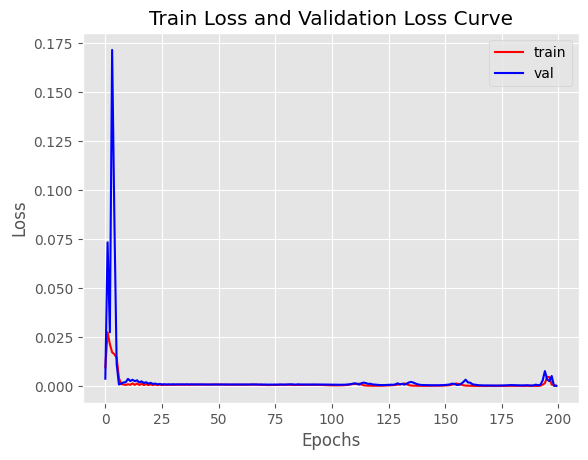

In [27]:
model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.0027752426950772703
RMSE = 0.052680572273631106
MAPE = 0.03286424913631933
R-Squared Score = 0.895392711000614


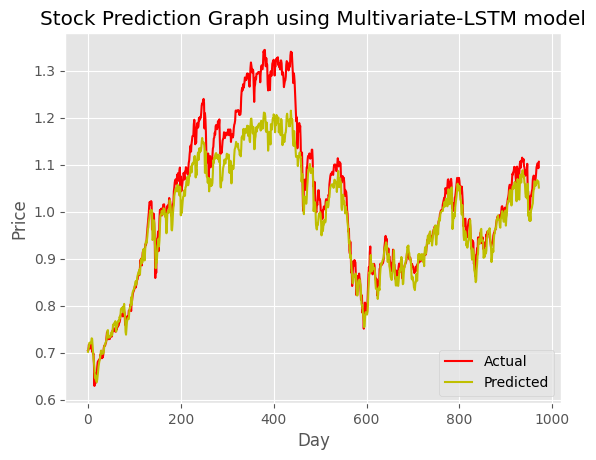

In [28]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_4(true, predicted)

In [29]:
# Save a model
#model.save('MV3-LSTM_50_[40,35]_1e-3_64.h5')
del model # Deletes the model